In [1]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white',context='notebook',palette='deep')

### 1. データのロードと確認

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
IDtest = test["PassengerId"]

* 外れ値の検出

In [3]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    for col in features:
        q1 = np.percentile(df[col],25)
        q3 = np.percentile(df[col],75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers

outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


ここでは数値データの外れ値を検出している．
モチベーションは外れ値はデータの全体の傾向をつかむ上で邪魔になるため．
Age,SibSp,Parch,Fareの4つに対してデータの四分位範囲をとり，第1・第3四分位数よりその数値分データが離れているものをここでは外れ値として扱い，複数あるものをここでは表示している

In [5]:
train = train.drop(outliers_to_drop,axis=0).reset_index(drop=True)

In [6]:
train_len = len(train)
train_len # trainの行数
dataset = pd.concat(objs = [train,test],axis=0,sort=True).reset_index(drop = True)

* データの欠損の検出

In [7]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

データの欠損値やnullの検出を行った結果としては
[Age,Cabin]に大量[Embarked,Fare]に少し検出された.
Survivedの欠損値はすべてテストデータによるものなので
実質欠損値はない

### 2. データに対する分析

ここでデータが何を表しているかをここに記す
   * PassengerId – 乗客識別ユニークID
   * Survived – 生存フラグ（0=死亡、1=生存）
   * Pclass – チケットクラス
   * Name – 乗客の名前
   * Sex – 性別（male=男性、female＝女性）
   * Age – 年齢
   * SibSp – タイタニックに同乗している兄弟/配偶者の数
   * parch – タイタニックに同乗している親/子供の数
   * ticket – チケット番号
   * fare – 料金
   * cabin – 客室番号
   * Embarked – 出港地（タイタニックへ乗った港）
   
参照([link](https://www.codexa.net/kaggle-titanic-beginner/))

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


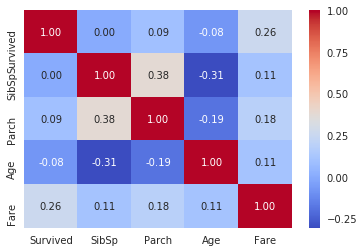

In [10]:
grah = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,fmt='.2f',cmap= 'coolwarm')

survivedの相関関係を見たがFareぐらいしか関係があまりなかった

* SibSp

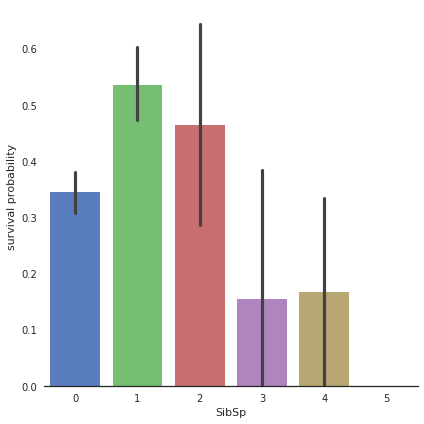

In [11]:
grap = sns.factorplot(x = "SibSp",y = "Survived",data = train,kind  = "bar",size = 6,palette = "muted")
grap.despine(left=True)
grap = grap.set_ylabels("survival probability")

SibSpはタイタニックに同乗している兄弟配偶者の数であるが，その数1,2人のときの生存率が高くなっている.逆に多くなると生存率が低くなっている

* Parch

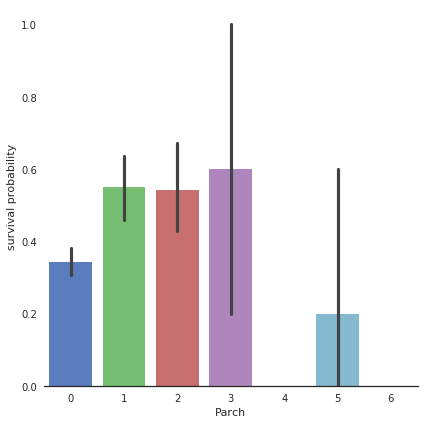

In [12]:
grap = sns.factorplot(x = "Parch",y = "Survived",data =train,kind = "bar",size = 6,palette = "muted")
grap.despine(left=True)
grap = grap.set_ylabels("survival probability")

Parchはタイタニックに同乗している子供もしくは親の数であるが人数がある程度少ない家族のほうが
独り身や大家族よりも生存率が高い.

* Age

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


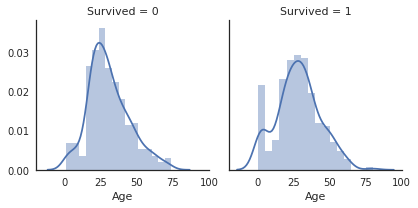

In [13]:
grap = sns.FacetGrid(train,col = 'Survived')
grap = grap.map(sns.distplot,"Age")

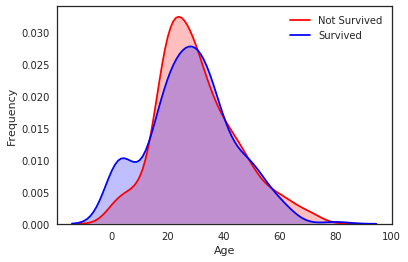

In [14]:
grap = sns.kdeplot(train["Age"][(train["Survived"] == 0 ) & (train["Age"].notnull())],color = "Red",shade=True)
grap = sns.kdeplot(train["Age"][(train["Survived"] == 1 ) & (train["Age"].notnull())],color = "Blue",shade=True)
grap.set_xlabel("Age")
grap.set_ylabel("Frequency")
grap = grap.legend(["Not Survived","Survived"])

Ageの場合だと0~10歳の子供の時に生存確率の違いが出ている

* Fare

In [15]:
dataset["Fare"].isnull().sum()

1

In [16]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


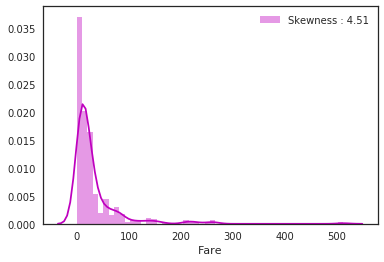

In [17]:
grap = sns.distplot(dataset["Fare"],color="m",label ="Skewness : {:.2f}".format(dataset["Fare"].skew()))
grap = grap.legend(loc = "best")

Fareは料金ですが，非常にデータが歪んでいるため(歪度が高い)モデルに重大な影響を与えかねません．
そのためこのようなデータは対数を取って歪みを抑える必要がある
また欠損値は中央値(Median)で対応した.

In [18]:
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i > 0 else 0)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


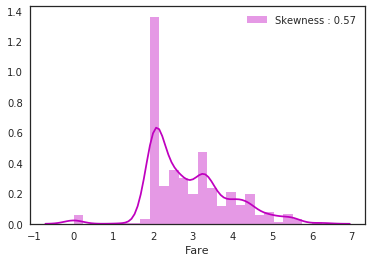

In [19]:
grap = sns.distplot(dataset["Fare"],color="m",label="Skewness : {:.2f}".format(dataset["Fare"].skew()))
grap = grap.legend(loc="best")

データの歪度を減らせたことがわかる

* Sex

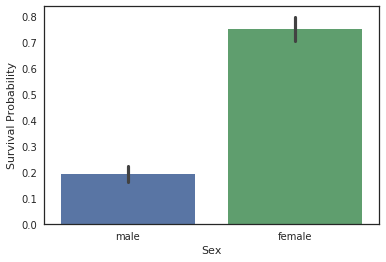

In [20]:
grap = sns.barplot(x = "Sex",y="Survived",data=train)
grap = grap.set_ylabel("Survival Probability")

In [21]:
train[["Sex","Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


このSexは明確に違いが出ていることがわかる.
女性のほうが圧倒的に生き残っている

* Pclass

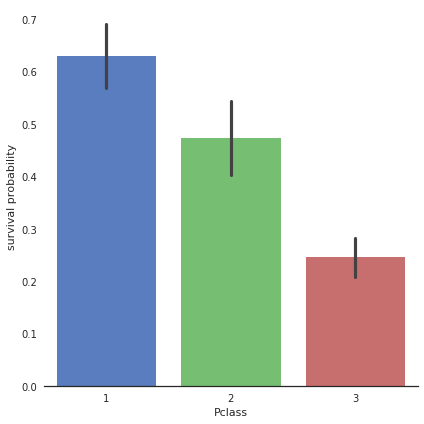

In [22]:
grap = sns.factorplot(x="Pclass",y="Survived",data=train,kind ="bar",size = 6,palette="muted")
grap.despine(left=True)
grap = grap.set_ylabels("survival probability")

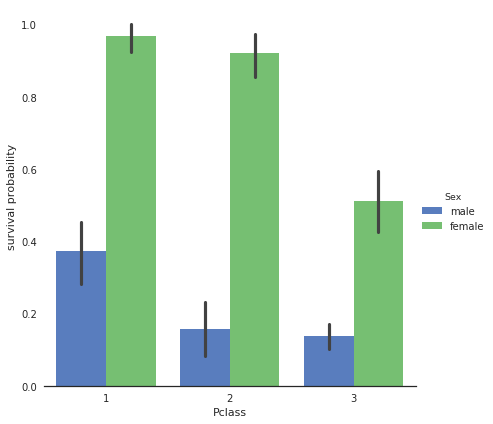

In [23]:
grap = sns.factorplot(x="Pclass",y="Survived",hue="Sex",data=train,size=6,kind="bar",palette="muted")
grap.despine(left=True)
grap = grap.set_ylabels("survival probability")

Pclassはチケットのランクで1が最も高く3がとても低い.
また性別とチケットのクラスについての分析を行うと1,2の女性は高い確率で生き残っている
ことがわかる

* Embarked

In [24]:
dataset["Embarked"].isnull().sum()

2

In [25]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

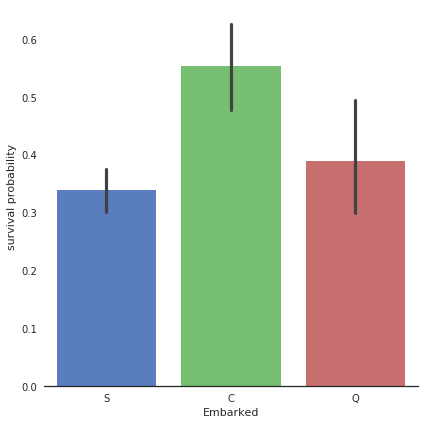

In [26]:
grap = sns.factorplot(x ="Embarked",y="Survived",data=train,size=6,kind="bar",palette="muted")
grap.despine(left=True)
grap = grap.set_ylabels("survival probability")

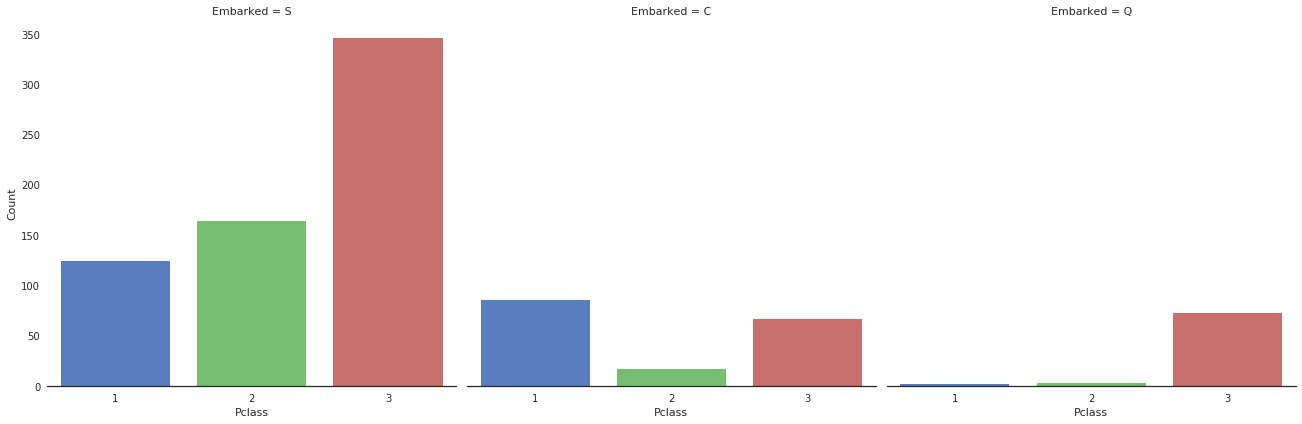

In [27]:
grap = sns.factorplot("Pclass",col = "Embarked",data=train,size=6,kind="count",palette="muted")
grap.despine(left=True)
grap = grap.set_ylabels("Count")

Embarkedはタイタニックに乗った港がどこであるかという情報である.  
その情報自体は生存確率とあまり関係ないように見られる.  
欠損値は一番多いSとおいた.
またチケットのクラスとの関係をplotした.3クラスの人はSとQに集中しているｋことがこの図からわかる

### 3. 欠損値の解決 

* Age

Ageには256の欠損値がある  
生存確率の高い部分(子供)があるのでその特徴を残しながら欠損値を埋めるのが好ましい  
そのためとりあえずAgeとSex,Parch,Pclass,SibSpの関係を見てみる

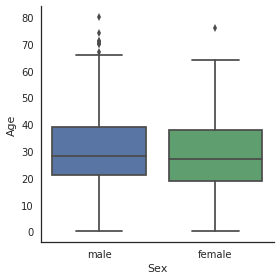

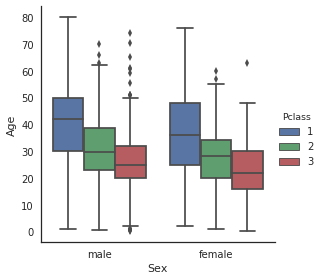

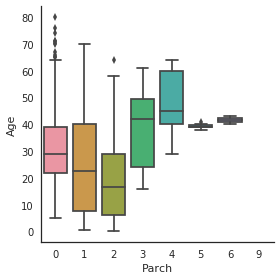

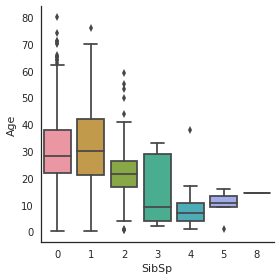

In [28]:
search_list  = ["Sex","Pclass","Parch","SibSp"]
for feature in search_list:
    if feature != "Pclass" :
        grap = sns.factorplot(y="Age",x = feature,data=dataset,kind="box")
    else:
        grap = sns.factorplot(y="Age",x="Sex",hue=feature,data=dataset,kind="box")

性別に年齢の違いは感じられない  
しかしながらチケットのクラスやParch,SibSpは年齢の欠損値を埋める上で  
重要な要素となり得ることが上の表からわかる

In [29]:
dataset["Sex"] = dataset["Sex"].map({"male":0,"female":1})

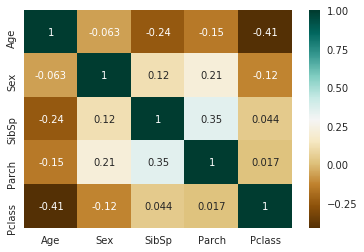

In [30]:
grap = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

相関関係を見るとやはりPclass,Parch,SibSpとは相関があることがわかる  
なので年齢の欠損値を埋めるために上記の特徴を利用する

In [31]:
index_nan_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_nan_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset["SibSp"] == dataset.iloc[i]["SibSp"]) & (dataset["Parch"] == dataset.iloc[i]["Parch"]) & (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


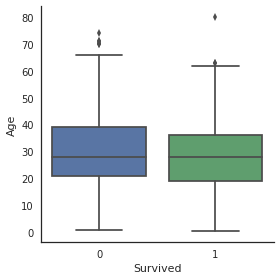

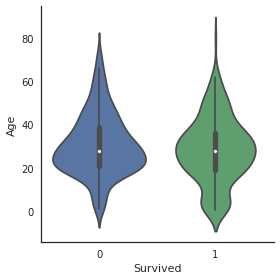

In [32]:
grap = sns.factorplot(x="Survived",y="Age",data=train,kind="box")
grap = sns.factorplot(x="Survived",y="Age",data=train,kind="violin")

### 4.特徴量作成

* Name

In [33]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

NameはMr,やMissの情報があるのでそれを特徴量として加えます.

In [34]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

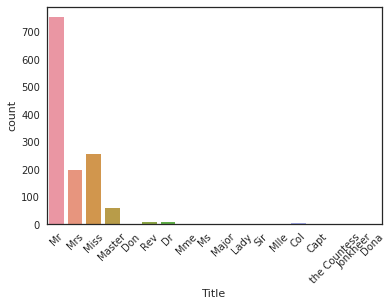

In [35]:
grap = sns.countplot(x="Title",data=dataset)
grap = plt.setp(grap.get_xticklabels(),rotation=45)

17個のTitle(Mr,Mrs等)の種類があるが大体は4つに分類されることがわかった.

In [36]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

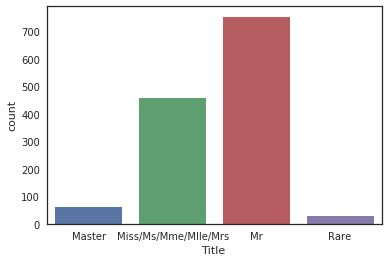

In [37]:
grap = sns.countplot(dataset["Title"])
grap = grap.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

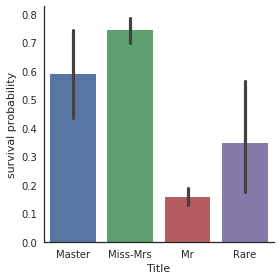

In [38]:
grap = sns.factorplot(x="Title",y="Survived",data = dataset,kind="bar")
grap = grap.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
grap = grap.set_ylabels("survival probability")

やはり女性の生存確率は高い  
またRareな人たちやMasterと呼ばれる人は生存確率が高い

In [39]:
dataset.drop(labels=["Name"],axis=1,inplace=True)

* Family size

タイタニックに乗っている家族の数は生存確率を決める上での特徴量の1つとして捉えられることができる.またそれはSibSpとParchの合計から1足した数で決まる

In [40]:
dataset["Fsize"]= dataset["SibSp"] + dataset["Parch"] + 1

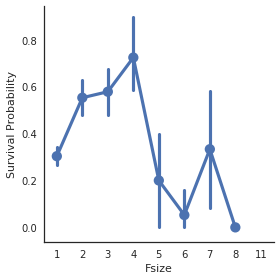

In [41]:
grap = sns.factorplot(x="Fsize",y="Survived",data=dataset)
grap = grap.set_ylabels("Survival Probability")

上記の表より生存確率と家族の数は非常に関係があるように思える．  
ここから家族の数を4つのクラスに分類する

In [42]:
dataset["Single"] = dataset["Fsize"].map(lambda s:1 if s==1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s:1 if s==2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s:1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s:1 if s >= 5 else 0)

In [43]:
family_list = ["Single","SmallF","MedF","LargeF"]

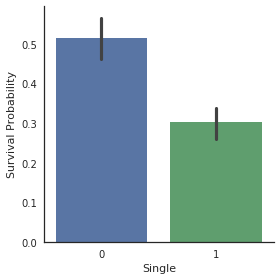

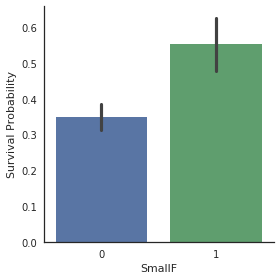

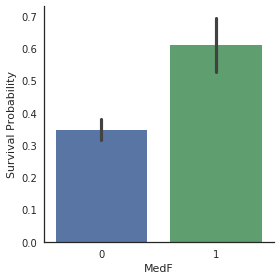

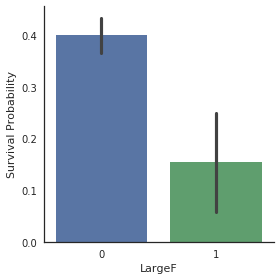

In [44]:
for i in family_list:
    grap = sns.factorplot(x=i,y="Survived",data=dataset,kind="bar")
    grap = grap.set_ylabels("Survival Probability")

SmallFとMedFはSingleやLargeFよりも生存確率が高い

ついでにカテゴリデータのTitleとEmbarkedにダミー変数をかけておく
  + ダミー変数 : ある 1 個の変数 X が m 個のカテゴリーを持つとき，これを m 個の変数 D1，D2，...，Dm で表したもの

In [45]:
dataset = pd.get_dummies(dataset,columns=["Title"])
dataset = pd.get_dummies(dataset,columns=["Embarked"],prefix="Em")

In [46]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


* Cabin

Cabinは客室番号です.  
Cabinはこの特徴量の中で唯一欠損値の量が元のデータの半数以上を示すデータです.  
なので欠損値であるかどうかも一つの重要な要素になります.

In [47]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [48]:
dataset["Cabin"].isnull().sum()

1007

In [49]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [50]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"]])

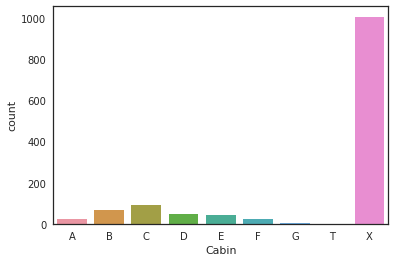

In [51]:
grap = sns.countplot(dataset["Cabin"],order=["A","B","C","D","E","F","G","T","X"])

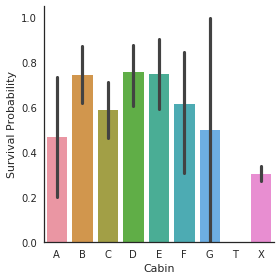

In [52]:
grap = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=["A","B","C","D","E","F","G","T","X"])
grap = grap.set_ylabels("Survival Probability")

客室は乗客のデータが少ないためデータの散らばりは大きいですが,  
客室を持っている人は持っていない人に比べて生存確率が高いことがわかります

In [53]:
dataset = pd.get_dummies(dataset,columns=["Cabin"],prefix="Cabin")

* Ticket

Ticketはタイタニックのチケット番号です
チケットの先頭についている情報は同じCabinやPclassの情報を含んでいる可能性があるのでそこを特徴量として取り入れることにします.

In [54]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [55]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        Ticket.append("X")
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [56]:
dataset = pd.get_dummies(dataset,columns=["Ticket"],prefix="T")

In [57]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset,columns=["Pclass"],prefix="Pc")

In [58]:
dataset.drop(labels=["PassengerId"],axis=1,inplace=True)

In [59]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


以上でデータをすべて数字に落とし込むことができたので次からモデルの作成を行っていきます

### 5. モデル作成

In [60]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [61]:
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"],axis=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


* 簡単なモデル

最初に簡単に10個の分類モデルで精度を評価する

   * SVC
   * Decision Tree
   * AdaBoost
   * Random Forest
   * Extra Trees
   * Gradient Boosting
   * Multiple layer perceprton (neural network)
   * KNN
   * Logistic regression
   * Linear Discriminant Analysis


In [62]:
kfold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn

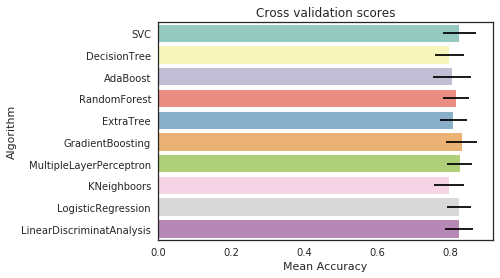

In [63]:
random_state=2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results =[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y=Y_train,scoring="accuracy",cv=kfold,n_jobs=8))

cv_means =[]
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors":cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTree","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminatAnalysis"]})

grap = sns.barplot("CrossValMeans","Algorithm",data=cv_res,palette="Set3",orient="h",**{"xerr":cv_std})
grap.set_xlabel("Mean Accuracy")
grap = grap.set_title("Cross validation scores")

今回はSVC,AdaBoost,RandomForest,ExtraTree,GradientBoostをアンサンブル学習に用います

* ハイパーパラメータの調整

AdaBoost,ExtraTrees,RandomForest,GradientBoostiong,SVCに対して  
ハイパーパラメータの調整を行います

In [64]:
#Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC,random_state=7)

ada_param_grid = {"base_estimator__criterion":["gini","entropy"],
                 "base_estimator__splitter":["best","random"],
                 "n_estimators":[1,2],
                 "learning_rate":[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring="accuracy",n_jobs=8,verbose=1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=8)]: Done 560 out of 560 | elapsed:    0.7s finished


In [65]:
gsadaDTC.best_score_

0.8240635641316686

In [66]:
#ExtraTrees
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid=ex_param_grid,cv=kfold,scoring="accuracy",n_jobs=4,verbose=1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   22.0s finished


0.8331441543700341

In [67]:
#RFC
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

gsRFC = GridSearchCV(RFC,param_grid=rf_param_grid,cv=kfold,scoring="accuracy",n_jobs=8,verbose=1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:   15.2s finished


0.8331441543700341

In [68]:
# Gradient boost 
GBC = GradientBoostingClassifier()

gb_param_grid = {"loss":["deviance"],
                "n_estimators":[100,200,300],
                "learning_rate":[0.1,0.05,0.01],
                "max_depth":[4,8],
                "min_samples_leaf":[100,150],
                "max_features":[0.3,0.1]}

gsGBC = GridSearchCV(GBC,param_grid=gb_param_grid,cv=kfold,scoring="accuracy",n_jobs=8,verbose=1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Done 124 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:    8.1s finished


0.8354143019296254

In [69]:
# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {"kernel":["rbf"],
                 "gamma":[0.001,0.01,0.1,1],
                 "C":[1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC,param_grid=svc_param_grid,cv=kfold,scoring="accuracy",n_jobs=8,verbose=1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   11.1s finished


0.8331441543700341

* 学習の進み具合

学習曲線を見ることでそのモデルが局所解や過学習を起こしているかなどを見ることができる

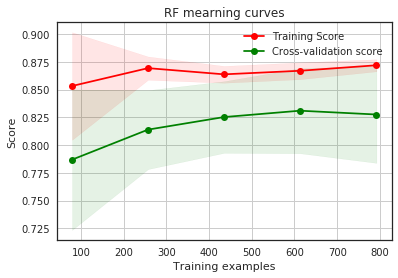

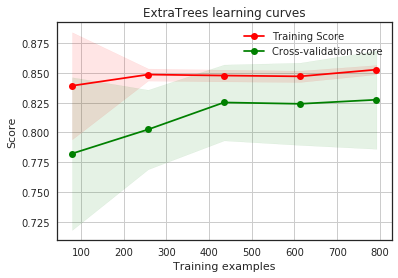

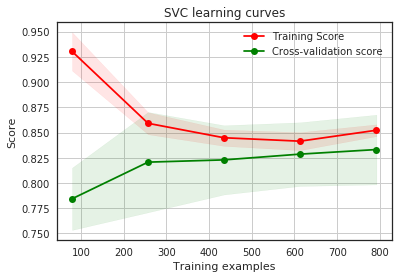

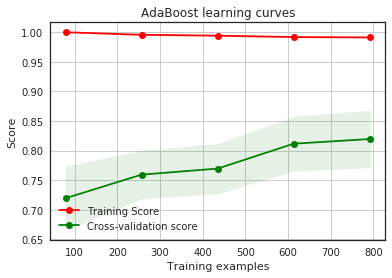

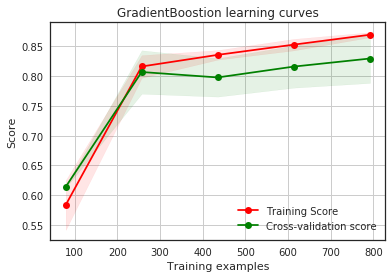

In [70]:
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=None,n_jobs=8,train_sizes=np.linspace(.1,1.0,5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes,train_scores,test_scores = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    plt.grid()

    
    plt.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean+train_scores_std,alpha=0.1,color="r")
    plt.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    plt.plot(train_sizes,train_scores_mean,"o-",color="r",label="Training Score")
    plt.plot(train_sizes,test_scores_mean,"o-",color="g",label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

grap = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
grap = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
grap = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
grap = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
grap = plot_learning_curve(gsGBC.best_estimator_,"GradientBoostion learning curves",X_train,Y_train,cv=kfold)

Adaboostは過学習の傾向があることが上記の表より読み取れる.
なので正則化やデータを増やすもしくはモデルを簡単にするなどすると精度が向上する.

* 特徴量の分類機による重要性

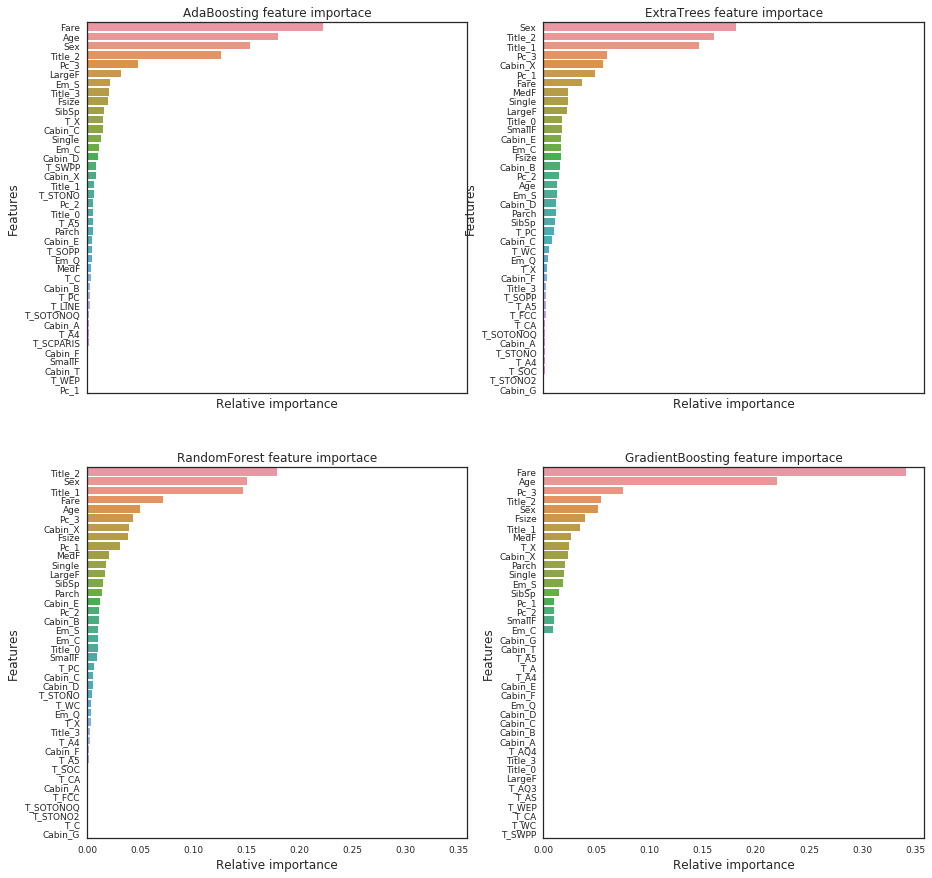

In [71]:
nrows = ncols = 2
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,sharex="all",figsize=(15,15))

name_classifiers=[("AdaBoosting",ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier=0
for row in range(nrows):
    for col in range(ncols):
        name = name_classifiers[nclassifier][0]
        classifier = name_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        grap = sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40],orient="h",ax=axes[row][col])
        grap.set_xlabel("Relative importance",fontsize=12)
        grap.set_ylabel("Features",fontsize=12)
        grap.tick_params(labelsize=9)
        grap.set_title(name + " feature importace")
        nclassifier += 1
        

それぞれの分類機における変数の重要度をplotしたものが上記のものになるが，すべての学習機が同様な重要度をつけているわけではない(故にアンサンブル学習が有効)  
また，性別や家族構成，その人の役職は生存を予測する上で重要な要素であることが示されている

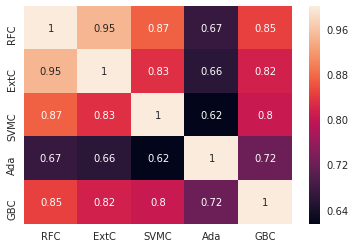

In [72]:
test_Survived_RFC = pd.Series(RFC_best.predict(test),name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test),name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test),name="SVMC")
test_Survived_AdaC = pd.Series(ada_best.predict(test),name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test),name="GBC")

ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_SVMC,test_Survived_AdaC,test_Survived_GBC],axis=1)

grap = sns.heatmap(ensemble_results.corr(),annot=True)

5つの分類機はそれぞれ似ている精度をAda以外出している.  
しかし，少しの違いを含んでいるためアンサンブルの材料にした時に全体の精度が上がる
可能性がある.

### 6アンサンブル学習とoutput

アンサンブルの説明に関しては下記のリンクよりどうぞ
  + アンサンブル学習([参照](https://www.codexa.net/what-is-ensemble-learning/))  
  
  
今回は簡単に多数決で決める.

In [73]:
votingC = VotingClassifier(estimators=[("rfc",RFC_best),("extc",ExtC_best),("svc",SVMC_best),("adac",ada_best),("gbc",GBC_best)],voting="soft",n_jobs=8)
votingC  = votingC.fit(X_train,Y_train)

最終結果をkaggleに提出できる形にする

In [74]:
test_Survived = pd.Series(votingC.predict(test),name="Survived")
results=pd.concat([IDtest,test_Survived],axis=1)
results.to_csv("ensemble_python_votion.csv",index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
